# Crowd Funding Study: Building a Machine Learning Binary Classification Model

#### Context: 
The data obtained from Form C filings was extracted through the utilization of the '*Scraper.py*' script, resulting in the accumulation of over 24,000 rows of scraped data, which was subsequently archived in the '*scrapedCrowdOfferingsData.csv*' file.

The '*DataCleaning.ipynb*' notebook offers a comprehensive account of the systematic data cleaning process and the creation of new features from the scraped dataset. The data is then aggregated and saved in the '*CrowdFundingCampaignsCleanedData.csv*' file. A public **Tableau dashboard** is also built with this data. 

In this notebook, additional data refinement and feature engineering procedures are conducted, resulting in the development of a machine learning model designed for **binary classification**. The model's objective is to predict the **success or failure of a crowdfunding campaign** based on specific user-provided input features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import ensemble
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import scikitplot as skplt


#### Data Loading



In [2]:
df= pd.read_csv('CrowdFundingCampaignsCleanedData.csv',index_col=None) 

In [3]:
df.head(3)

,fileNumber,accessionNumber,countFilings,countAmendments,countProgressUpdates,latestProgressUpdate,quarter,companyAge,initialTargetOffering,finalTargetOffering,...,dateIncorporation,city,stateOrCountry,zipCode,issuerWebsite,filingDate,IntermediaryName,state (US),Country,Platform
0,020-30813,0001665160-22-002309,4,1,1,"At the close of the offering, the issuer close...",3Q,1946,10000.00,10000.00,...,2017-05-01,New York,NY,10282,https://milorx.com,2022-08-29,StartEngine,NEW YORK,United States,StartEngine
1,020-28025,0001665160-21-000877,6,3,2,Adjustment to the initial Form C-U filing. At ...,2Q,1248,9999.64,9999.64,...,2017-12-02,Las Vegas,NV,89115,https://www.boxabl.com/,2021-05-03,StartEngine,NEVADA,United States,StartEngine
2,020-27789,0001532978-21-000001,4,1,1,"The Offering closed successfully on April 7, 2...",1Q,3462,25000.00,25000.00,...,2011-09-22,San Francisco,CA,94104,http://gumroad.com,2021-03-15,Republic,CALIFORNIA,United States,Republic


In [4]:
print(df.select_dtypes(include= 'number').columns.tolist()) #numerical columns

['countFilings', 'countAmendments', 'countProgressUpdates', 'companyAge', 'initialTargetOffering', 'finalTargetOffering', 'unknownProgressUpdate', 'raisedAmount', 'noOfSecurityOffered', 'price', 'maximumOfferingAmount', 'currentEmployees', 'totalAssetMostRecentFiscalYear', 'totalAssetPriorFiscalYear', 'cashEqMostRecentFiscalYear', 'cashEqPriorFiscalYear', 'accountsReceivedRecentFiscalYear', 'accountsReceivedPriorFiscalYear', 'shortTermDebtMRecentFiscalYear', 'shortTermDebtPriorFiscalYear', 'longTermDebtRecentFiscalYear', 'longTermDebtPriorFiscalYear', 'revenueMostRecentFiscalYear', 'revenuePriorFiscalYear', 'costGoodsSoldRecentFiscalYear', 'costGoodsSoldPriorFiscalYear', 'taxPaidMostRecentFiscalYear', 'taxPaidPriorFiscalYear', 'netIncomeMostRecentFiscalYear', 'netIncomePriorFiscalYear']


In [5]:
print(df.select_dtypes(include= 'object').columns.tolist()) # categorical columns 

['fileNumber', 'accessionNumber', 'latestProgressUpdate', 'quarter', 'initialCampaignDeadline', 'finalCampaignDeadline', 'securityOfferedType', 'oversubscriptionAccepted', 'oversubscriptionAllocationType', 'issuerName', 'legalStatusForm', 'dateIncorporation', 'city', 'stateOrCountry', 'zipCode', 'issuerWebsite', 'filingDate', 'IntermediaryName', 'state (US)', 'Country', 'Platform']


### Data Modeling


In [6]:
dataModel=df.copy()

#### Feature Engineering: Creating New Features of Campaign Duration and Campaign Status
- A whole list of features where defined in the DataCleaning.ipynb
- An Additional feature 'campaignDuration' is defined below


In [7]:
dataModel['campaignDuration']= (pd.to_datetime(dataModel['finalCampaignDeadline']) - pd.to_datetime(dataModel['filingDate'])).dt.days 

campaignStatus is the **target y** chosen for this study, which is defined as campaigns where the raisedAmount is greater than or equal to the initial target offering amount

In [8]:
dataModel['campaignStatus'] = dataModel.apply(lambda row: 1 if (row['raisedAmount'] >= row['initialTargetOffering']) else 0, axis=1) 

In the next step, we have removed indexing columns like 'fileNumber' and 'accessionNumber' since they do not provide any information that is useful for building the model. 

Additionally, relevant features like 'CompanyAge' and 'Campaign Duration', previously derived, already incorporate essential model building information from date type columns, such as 'dateIncorporation,' 'filingDate,' 'initialCampaignDeadline,' and 'finalCampaignDeadline'. Therefore, we have also eliminated these columns.

Furthermore, columns like 'countFilings,' 'countAmendments,' and 'countProgressUpdates' contain information about the campaign's progress. However, the model we are developing aims to predict outcomes based on the initial filing information, so we have also removed these columns.

Other columns are not relevant for building model like ['city', 'zipCode', 'issuerWebsite','state (US)', 'Country']


In [9]:
columns_to_drop= ['fileNumber', 'accessionNumber', 'countFilings','raisedAmount', 'countAmendments', 'countProgressUpdates', 'latestProgressUpdate', 'finalTargetOffering', 'initialCampaignDeadline', 'finalCampaignDeadline',
  'unknownProgressUpdate', 'oversubscriptionAllocationType',  'issuerName', 'dateIncorporation',  'filingDate','city', 'zipCode', 'issuerWebsite','state (US)', 'Country','Platform']


dataModel.drop(columns_to_drop, inplace= True, axis=1)

In [10]:
dataModel.info() # data types and no of null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   quarter                           6938 non-null   object 
 1   companyAge                        6938 non-null   int64  
 2   initialTargetOffering             6938 non-null   float64
 3   securityOfferedType               6938 non-null   object 
 4   noOfSecurityOffered               5220 non-null   float64
 5   price                             6541 non-null   float64
 6   oversubscriptionAccepted          6938 non-null   object 
 7   maximumOfferingAmount             6847 non-null   float64
 8   currentEmployees                  6938 non-null   int64  
 9   totalAssetMostRecentFiscalYear    6938 non-null   float64
 10  totalAssetPriorFiscalYear         6938 non-null   float64
 11  cashEqMostRecentFiscalYear        6938 non-null   float64
 12  cashEq

In [11]:
#These columns were dropped because no of security offered x price= initial target offering, so it was already included in intitial target offering
dataModel.drop(['noOfSecurityOffered','price'], inplace= True, axis=1) 

The 'maximumOfferingAmount' is the permitted offering amount in cases where oversubscription is allowed (when 'oversubscriptionAccepted' is 'Y'). It is null for cases where oversubscription is not allowed. In the next step, for these cases, we will assign the 'initialTargetOffering' to be equal to the 'maximumOfferingAmount.'

In [12]:
dataModel['maximumOfferingAmount'].fillna(dataModel['initialTargetOffering'], inplace=True)

**Outliers?**  The knowledge of domain often helps to quickly eliminate some outliers. In the next step we have a quick look for any cases where the net income is greater than revenue, which is not possible under standard accounting principles and so will be treated like outliers and removed from dataset. 

In [13]:
len(dataModel[(dataModel['netIncomeMostRecentFiscalYear']> dataModel['revenueMostRecentFiscalYear']) | (dataModel['netIncomePriorFiscalYear']> dataModel['revenuePriorFiscalYear'])])

140

In [14]:
# Outliers are removed, net income can't be more than revenue
dataModel= dataModel[(dataModel['netIncomeMostRecentFiscalYear']<= dataModel['revenueMostRecentFiscalYear']) & (dataModel['netIncomePriorFiscalYear']<= dataModel['revenuePriorFiscalYear'])]

In [15]:
dataModel= dataModel[dataModel['campaignDuration']>=0]

 In the next step, 90% of the data is selected for training while keeping the rest 10% of the data for testing purposes. 

In [16]:
X= dataModel.loc[:, dataModel.columns != "campaignStatus"]
y = dataModel.loc[:, "campaignStatus"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

In [17]:
# Defining one hot encoder for categorical variables
def one_hot_encode_data(X_train, X_test): 

    object_cols= X_train.select_dtypes(['object']).columns.tolist()

    # Apply one-hot encoder to each column with categorical data
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # New in version 1.2: sparse was renamed to sparse_output
    
    X_train_ohe = OH_encoder.fit_transform(X_train[object_cols])
    X_test_ohe = OH_encoder.transform(X_test[object_cols])

    cols_ohe = OH_encoder.get_feature_names_out() 
    OH_cols_train = pd.DataFrame(X_train_ohe, columns= cols_ohe)
    OH_cols_test = pd.DataFrame(X_test_ohe, columns= cols_ohe)

    # One-hot encoding removed index; put it back
    OH_cols_train.index = X_train.index
    OH_cols_test.index = X_test.index

    X_train_num= X_train.drop(object_cols, axis=1)
    X_test_num= X_test.drop(object_cols, axis=1)

    OH_X_train = pd.concat([X_train_num, OH_cols_train], axis=1)
    OH_X_test = pd.concat([X_test_num, OH_cols_test], axis=1)

    # Ensure all columns have string type
    OH_X_train.columns = OH_X_train.columns.astype(str)
    OH_X_test.columns = OH_X_test.columns.astype(str)

    return OH_X_train, OH_X_test

#### Building The Initial ML Model With Random Forests

In [18]:
rf = ensemble.RandomForestClassifier(
    n_estimators=200, # default 100
    max_features= 'sqrt',       #'sqrt,' which means it will use the square root of the number of features as the maximum number of features to consider when making splits
    random_state= 0, #random state to zero
)

OH_X_train, OH_X_test=  one_hot_encode_data(X_train, X_test)

rf.fit(OH_X_train, y_train)
y_pred = rf.predict(OH_X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       391
           1       0.71      0.76      0.73       289

    accuracy                           0.77       680
   macro avg       0.76      0.77      0.76       680
weighted avg       0.77      0.77      0.77       680



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

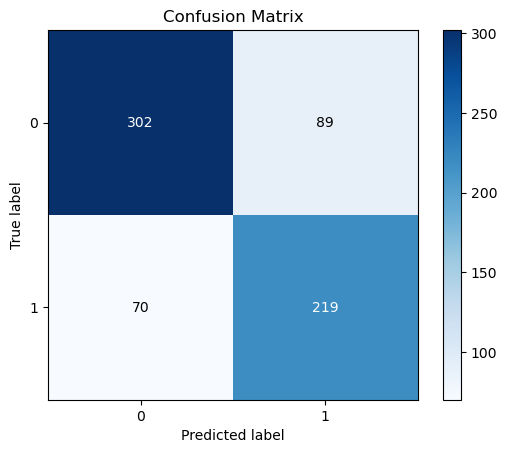

In [20]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

#### Cross Validating the Initial Model

In [21]:
#X_encoded= pd.get_dummies(X, drop_first=True) # one hot encodes without labels
#cv_accuracy = cross_val_score(rf, X_encoded, y, cv=5, scoring='accuracy') #using cross validated sample

#cv_accuracy = cross_val_score(rf, OH_X, y, cv=5, scoring='accuracy') #using cross validated sample
cv_accuracy = cross_val_score(rf, OH_X_train, y_train, cv=5, scoring='accuracy') #using cross validated sample

print(f"Cross-validation accuracies:{cv_accuracy}" )
print(f"Mean accuracy:{cv_accuracy.mean()*100: .2f}")

Cross-validation accuracies:[0.74836601 0.77677841 0.77023712 0.75470155 0.75960752]
Mean accuracy: 76.19


 The mean cross-validation accuracy result (76.2%) matches to 77% accuracy obtained on the test datatset. Also, the range of values obtained with cross validation is not varying a lot, which indicates that the model generalizes reasonably well

#### Determining a Benchmark Score for the Binary Classification Model: Majority Class

In [22]:
# Determining benchmark score based on Majority Class

successfulCampaigns_percent= (dataModel['campaignStatus'].sum()/len(dataModel))*100 # % of successful campaigns in the dataset

print(f'% of majority class (unsuccessful campaigns) in the dataset {(100- successfulCampaigns_percent):.2f} %')

% of majority class (unsuccessful campaigns) in the dataset 57.67 %


##### Comparison of Initial Model with baseline
*The majority (57.7%) of the campaigns are unsuccessful. This would be the **benchmark score** since by always predicting 'unsuccessful campaigns' one would be accurate 57.7% of time*. The accuracy provided by the initial random forest model (77%) is there a significant improvement over the benchmark accuracy. 

#### Cardinality of Categorical Variables

High cardinality categorical features can be reduced by creating aggregations, resulting in reduced dimensionality and often leading to improved model performance. In the upcoming steps, we will explore the aggregation of two high cardinality categorical features: 'IntermediaryName' and 'stateOrCountry.'

In [23]:
print(f"Cardinality of IntermediaryName: {X['IntermediaryName'].nunique()} and Cardinality of stateOrCountry: {X['stateOrCountry'].nunique()}")

Cardinality of IntermediaryName: 110 and Cardinality of stateOrCountry: 67


### Feature Engineering: Group Transformation of High Cardinality Features
- The idea is to create new features by creating Aggregations via Group Transformations (Average/ Frequency) on the high cardinality columns: IntermediaryName and stateOrCountry, thereby reducing the dimensionality of the dataset while preserving or perhaps enhancing value via noise reduction

In [24]:
X_train["IntermediaryFreq"] = (X_train.groupby("IntermediaryName")["IntermediaryName"].transform("count")/ X_train["IntermediaryName"].count())
X_train["avgTargetOfferingByIntermediary"] = X_train.groupby("IntermediaryName")["initialTargetOffering"].transform("mean") # Avg of maximumOfferingAmount was also tested but produced inferior results

X_train["stateOrCountryFreq"] = (X_train.groupby("stateOrCountry")["stateOrCountry"].transform("count")/ X_train["stateOrCountry"].count())
X_train["avgTargetOfferingByStateOrCountry"] = X_train.groupby("stateOrCountry")["initialTargetOffering"].transform("mean")

X_train[["IntermediaryName", "IntermediaryFreq","avgTargetOfferingByIntermediary","stateOrCountry", "stateOrCountryFreq","avgTargetOfferingByStateOrCountry"]].head(3)

,IntermediaryName,IntermediaryFreq,avgTargetOfferingByIntermediary,stateOrCountry,stateOrCountryFreq,avgTargetOfferingByStateOrCountry
5632,StartEngine,0.209451,12775.586831,CA,0.244931,74318.325040
5021,Wefunder Portal LLC,0.257848,104877.921630,CA,0.244931,74318.325040
4213,Buy The Block,0.003434,67205.952381,FL,0.070798,57042.682309


In [25]:
# Merge the frequencies from X_train into X_test based on "IntermediaryName"
X_test = pd.merge(X_test, X_train[["IntermediaryName", "IntermediaryFreq","avgTargetOfferingByIntermediary"]].drop_duplicates(), on='IntermediaryName', how='left')
X_test = pd.merge(X_test, X_train[["stateOrCountry", "stateOrCountryFreq","avgTargetOfferingByStateOrCountry"]].drop_duplicates(), on='stateOrCountry', how='left')

The these **mappings** "IntermediaryFreq","avgTargetOfferingByIntermediary" to the "IntermediaryName" and the "stateOrCountry" to "stateOrCountryFreq","avgTargetOfferingByStateOrCountry" are saved to excel files, to be used later to manipulate the user inputs for the cloud deployed app.

In [26]:
X_train[["IntermediaryName", "IntermediaryFreq","avgTargetOfferingByIntermediary"]].drop_duplicates().to_excel('intermediaryFreqMapping.xlsx', index=False)
X_train[["stateOrCountry", "stateOrCountryFreq","avgTargetOfferingByStateOrCountry"]].drop_duplicates().to_excel('stateOrCountryFreqMapping.xlsx', index=False)

In [27]:
# Fill any missing values (e.g., for those IntermediaryNames, stateOrCountry  not found in X_train) with 0
X_test['IntermediaryFreq'].fillna(0, inplace=True)
X_test['stateOrCountryFreq'].fillna(0, inplace=True)
X_test['avgTargetOfferingByIntermediary'].fillna(0, inplace=True)
X_test['avgTargetOfferingByStateOrCountry'].fillna(0, inplace=True)

# Drop the original Categorical Columns 
X_train.drop(columns= ['IntermediaryName','stateOrCountry'], axis=1, inplace=True)
X_test.drop(columns= ['IntermediaryName','stateOrCountry'], axis=1, inplace=True)

#rest the training and test indexes
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [28]:
numerical_cols= X_train.select_dtypes('number').columns.tolist() # recording the numerical and categoricals columns
categorical_cols= X_train.select_dtypes('object').columns.tolist()
print('Numerical columns:', numerical_cols)
print('Categorical columns:', categorical_cols)

Numerical columns: ['companyAge', 'initialTargetOffering', 'maximumOfferingAmount', 'currentEmployees', 'totalAssetMostRecentFiscalYear', 'totalAssetPriorFiscalYear', 'cashEqMostRecentFiscalYear', 'cashEqPriorFiscalYear', 'accountsReceivedRecentFiscalYear', 'accountsReceivedPriorFiscalYear', 'shortTermDebtMRecentFiscalYear', 'shortTermDebtPriorFiscalYear', 'longTermDebtRecentFiscalYear', 'longTermDebtPriorFiscalYear', 'revenueMostRecentFiscalYear', 'revenuePriorFiscalYear', 'costGoodsSoldRecentFiscalYear', 'costGoodsSoldPriorFiscalYear', 'taxPaidMostRecentFiscalYear', 'taxPaidPriorFiscalYear', 'netIncomeMostRecentFiscalYear', 'netIncomePriorFiscalYear', 'campaignDuration', 'IntermediaryFreq', 'avgTargetOfferingByIntermediary', 'stateOrCountryFreq', 'avgTargetOfferingByStateOrCountry']
Categorical columns: ['quarter', 'securityOfferedType', 'oversubscriptionAccepted', 'legalStatusForm']


In [29]:
# One Hot Encoding the New Train and Test Dataset following the Aggregations
OH_X_train, OH_X_test=  one_hot_encode_data(X_train, X_test)

In [30]:
cv_accuracy = cross_val_score(rf, OH_X_train, y_train, cv=5, scoring='accuracy') #using cross validated sample

print(f"Cross-validation accuracies:{cv_accuracy}" )
print(f"Mean accuracy:{cv_accuracy.mean()*100: .2f}")

Cross-validation accuracies:[0.7630719  0.7792314  0.7792314  0.76042518 0.76042518]
Mean accuracy: 76.85


In [31]:
rf = ensemble.RandomForestClassifier(
    n_estimators=200, # default 100
    max_features= 'sqrt',       #'sqrt,' which means it will use the square root of the number of features as the maximum number of features to consider when making splits
    random_state= 0, #random state to zero    

)

rf.fit(OH_X_train, y_train)
y_pred = rf.predict(OH_X_test)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       391
           1       0.71      0.76      0.74       289

    accuracy                           0.77       680
   macro avg       0.76      0.77      0.77       680
weighted avg       0.77      0.77      0.77       680



#### Results from Group Transformations
- 1%-point increase in precision for unsucessful campaigns while 1%-point increase in f1-score in successful campaigns

### Recursive Feature Elimination (RFE)

- Here we attempt to reduce features which have very minimum impact on the model and in fact may be reducing the accuracy of the model by introducing noise
- Here we only attempt to eliminate numerical features from 'numerical_cols' list determined previously prior to one-hot encoding X_train, X_test
- RFE is an iterative process in which a single feature is removed at each step, and the accuracy of the model determined to ensure that only the features which have the least impact on the model are eliminated first. 

In [33]:
# Determining the baseline accuracy with only numerical features
rf.fit(OH_X_train[numerical_cols], y_train)
y_pred = rf.predict(OH_X_test[numerical_cols])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       391
           1       0.71      0.76      0.73       289

    accuracy                           0.76       680
   macro avg       0.76      0.76      0.76       680
weighted avg       0.77      0.76      0.76       680



**76% accuracy** above is the baseline accuracy with only the numerical features considered. The idea is that post feature elimination by RFE of numerical features, the accuracy obtained will be at or above this baseline.  

In [34]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# n_features_to_select is the final columns remaining at the end of RFE. This is a bit of trial and error, where it was determined that columns less than 10 decreases the accuracy of model
rfe = RFE(estimator= rf, n_features_to_select=10, step=1) # 10 features remaining after elimination and 1 feature removed at each step

In [36]:
# Fit the RFE selector on the training data
rfe.fit(OH_X_train[numerical_cols], y_train)

RFE(estimator=RandomForestClassifier(n_estimators=200, random_state=0),
    n_features_to_select=10)

In [37]:
# Get the selected features
selected_features = np.where(rfe.support_)[0] #indices of selected features
X_train_selected_RFE = OH_X_train[numerical_cols].iloc[:, selected_features]
X_test_selected_RFE = OH_X_test[numerical_cols].iloc[:, selected_features]

In [38]:
rf.fit(X_train_selected_RFE, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [39]:
# Make predictions on the test data
y_pred_RFE = rf.predict(X_test_selected_RFE)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred_RFE)
print(f"Accuracy on the selected features: {accuracy:.2f}")

Accuracy on the selected features: 0.77


In [40]:
print(classification_report(y_test, y_pred_RFE))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       391
           1       0.73      0.74      0.74       289

    accuracy                           0.77       680
   macro avg       0.77      0.77      0.77       680
weighted avg       0.77      0.77      0.77       680



In [49]:
cv_accuracy = cross_val_score(rf, X_train_selected_RFE, y_train, cv=5, scoring='accuracy') #using cross validated sample

print(f"Cross-validation accuracies:{cv_accuracy}" )
print(f"Mean accuracy:{cv_accuracy.mean()*100: .2f}")

Cross-validation accuracies:[0.7622549  0.77596075 0.78004906 0.74979558 0.76533115]
Mean accuracy: 76.67


In [41]:
numerical_cols_RFE= X_train_selected_RFE.columns.tolist()
numerical_cols_RFE

['companyAge',
 'initialTargetOffering',
 'maximumOfferingAmount',
 'totalAssetMostRecentFiscalYear',
 'cashEqMostRecentFiscalYear',
 'netIncomeMostRecentFiscalYear',
 'campaignDuration',
 'IntermediaryFreq',
 'avgTargetOfferingByIntermediary',
 'avgTargetOfferingByStateOrCountry']

Compared to baseline, RFE actually increased the accuracy of the model in the test data by 1-% point by eliminating features that were adding noise. 

The **10 final numerical features** selected were: *'companyAge', 'initialTargetOffering', 'maximumOfferingAmount', 'totalAssetMostRecentFiscalYear', 'cashEqMostRecentFiscalYear', 'netIncomeMostRecentFiscalYear', 'campaignDuration', 'IntermediaryFreq', 'avgTargetOfferingByIntermediary', 'avgTargetOfferingByStateOrCountry'*

#### Determining the accuracy by considering both categorical columns and the RFE determined numerical columns

In [42]:
# The features reduced from RFE above are initialized here to save compute time from RFE during reruns
numerical_cols_RFE= ['companyAge', 'initialTargetOffering', 'maximumOfferingAmount', 'totalAssetMostRecentFiscalYear', 'cashEqMostRecentFiscalYear', 'netIncomeMostRecentFiscalYear',
 'campaignDuration', 'IntermediaryFreq', 'avgTargetOfferingByIntermediary', 'avgTargetOfferingByStateOrCountry']

In [43]:
OH_X_train= pd.concat([OH_X_train[numerical_cols_RFE], OH_X_train.drop(columns= numerical_cols,axis=1)], axis=1)
OH_X_test= pd.concat([OH_X_test[numerical_cols_RFE], OH_X_test.drop(columns= numerical_cols,axis=1)], axis=1)

In [47]:
rf.fit(OH_X_train, y_train)
y_pred = rf.predict(OH_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       391
           1       0.72      0.73      0.72       289

    accuracy                           0.76       680
   macro avg       0.76      0.76      0.76       680
weighted avg       0.76      0.76      0.76       680



In [48]:
cv_accuracy = cross_val_score(rf, OH_X_train, y_train, cv=5, scoring='accuracy') #using cross validated sample

print(f"Cross-validation accuracies:{cv_accuracy}" )
print(f"Mean accuracy:{cv_accuracy.mean()*100: .2f}")

Cross-validation accuracies:[0.75980392 0.78413737 0.79231398 0.75061325 0.77350777]
Mean accuracy: 77.21


Despite the RFE model with both numerical and categorical columns having a marginally lower test accuracy (76%) compared to the numerical-only model (77%), its higher cross-validation accuracy of 77.21% (versus 76.67%) suggests that including both types of columns offers better generalization for future models.

<Axes: xlabel='feature'>

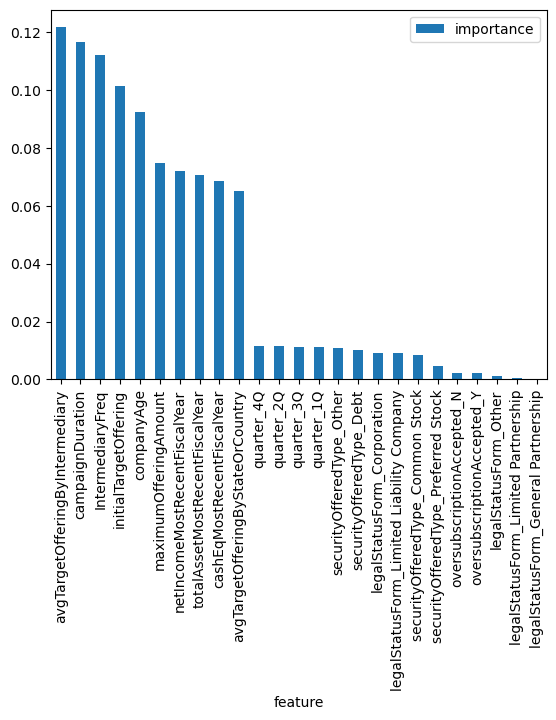

In [45]:
fi = rf.feature_importances_

feature_cols = OH_X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)

importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:30].plot(x="feature", y="importance", kind="bar")

Text(0.5, 1.0, 'Pearson Correlation Heatmap of numerical features')

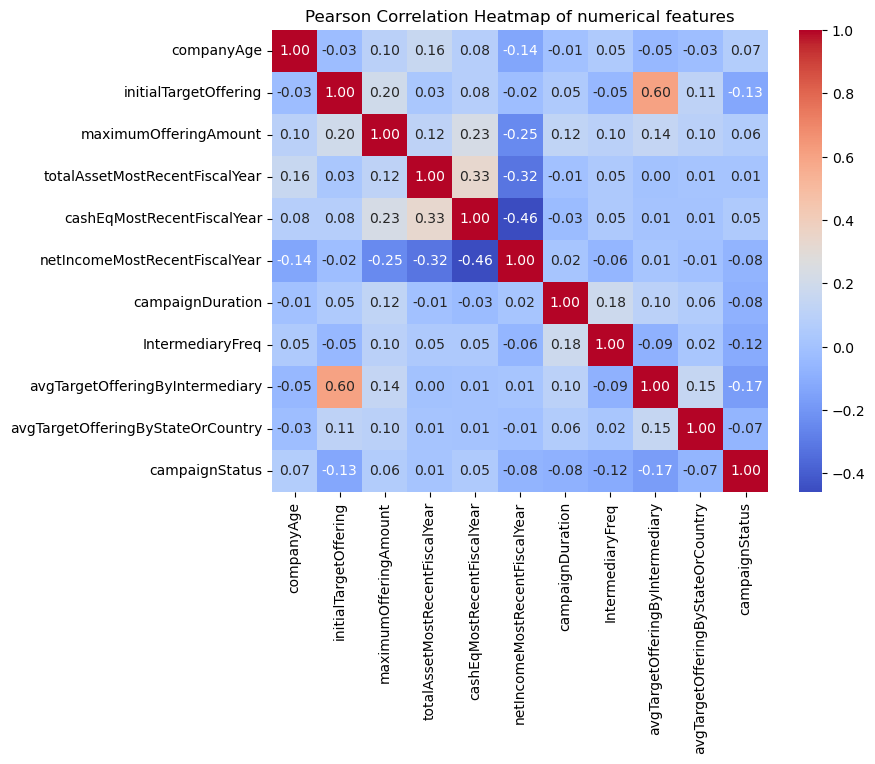

In [50]:
#Pearson correlation Heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

sns.heatmap(pd.concat([OH_X_train[numerical_cols_RFE], y_train], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Heatmap of numerical features')

#### Observations on the Correlations

- Crowfunding funding campaign is more likely to be successful when
    - Company is older
    - The initial target offering is a lower amount
    - the maximum offering amount in case of subscriptions is higher
    - cash equivalent in the most recent fiscal year is higher and is more relevant than total assets in the most recent fiscal year.
    - The campaign duration is shorter
    - Surprisingly, 
        - the netincome in the most recent fiscal year is lower. This might be due to **higher growth companies have negative net income**
        - IntermediaryFreq is relatively lower -> not the most frequently used intermediary platforms *(can be seen in the lower median line of the box plot below)*
        - The intermediary platform used offers relatively lower average target offerings 

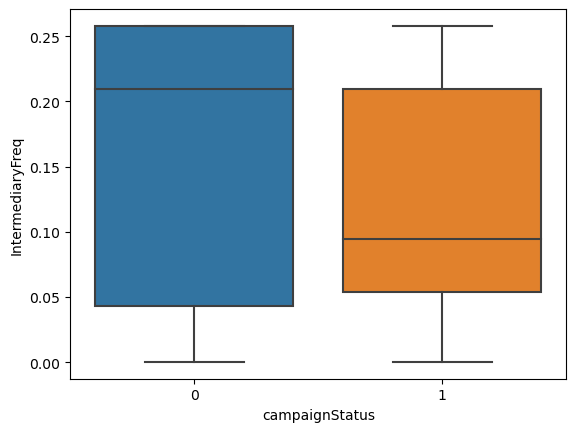

In [51]:
sns.boxplot(x= 'campaignStatus', y='IntermediaryFreq', data=pd.concat([OH_X_train, y_train], axis=1))
#sns.boxplot(x= 'campaignStatus', y='campaignDuration', data=pd.concat([OH_X_train, y_train], axis=1))
#sns.boxplot(x= 'campaignStatus', y='netIncomeMostRecentFiscalYear', data=pd.concat([OH_X_train, y_train], axis=1))
plt.show()


#### Outlier Determination

- Determine feature most closely resembling gaussian distribution with or without transformation and then use Box plots to determine outliers

A **log transformation** is applied on the plotted data in order to quickly visualize histograms of skewed data which features most closely resembles normal distribution following a log transformation

c:\Users\apsin\anaconda3\envs\Aadi\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\apsin\anaconda3\envs\Aadi\Lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\apsin\anaconda3\envs\Aadi\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


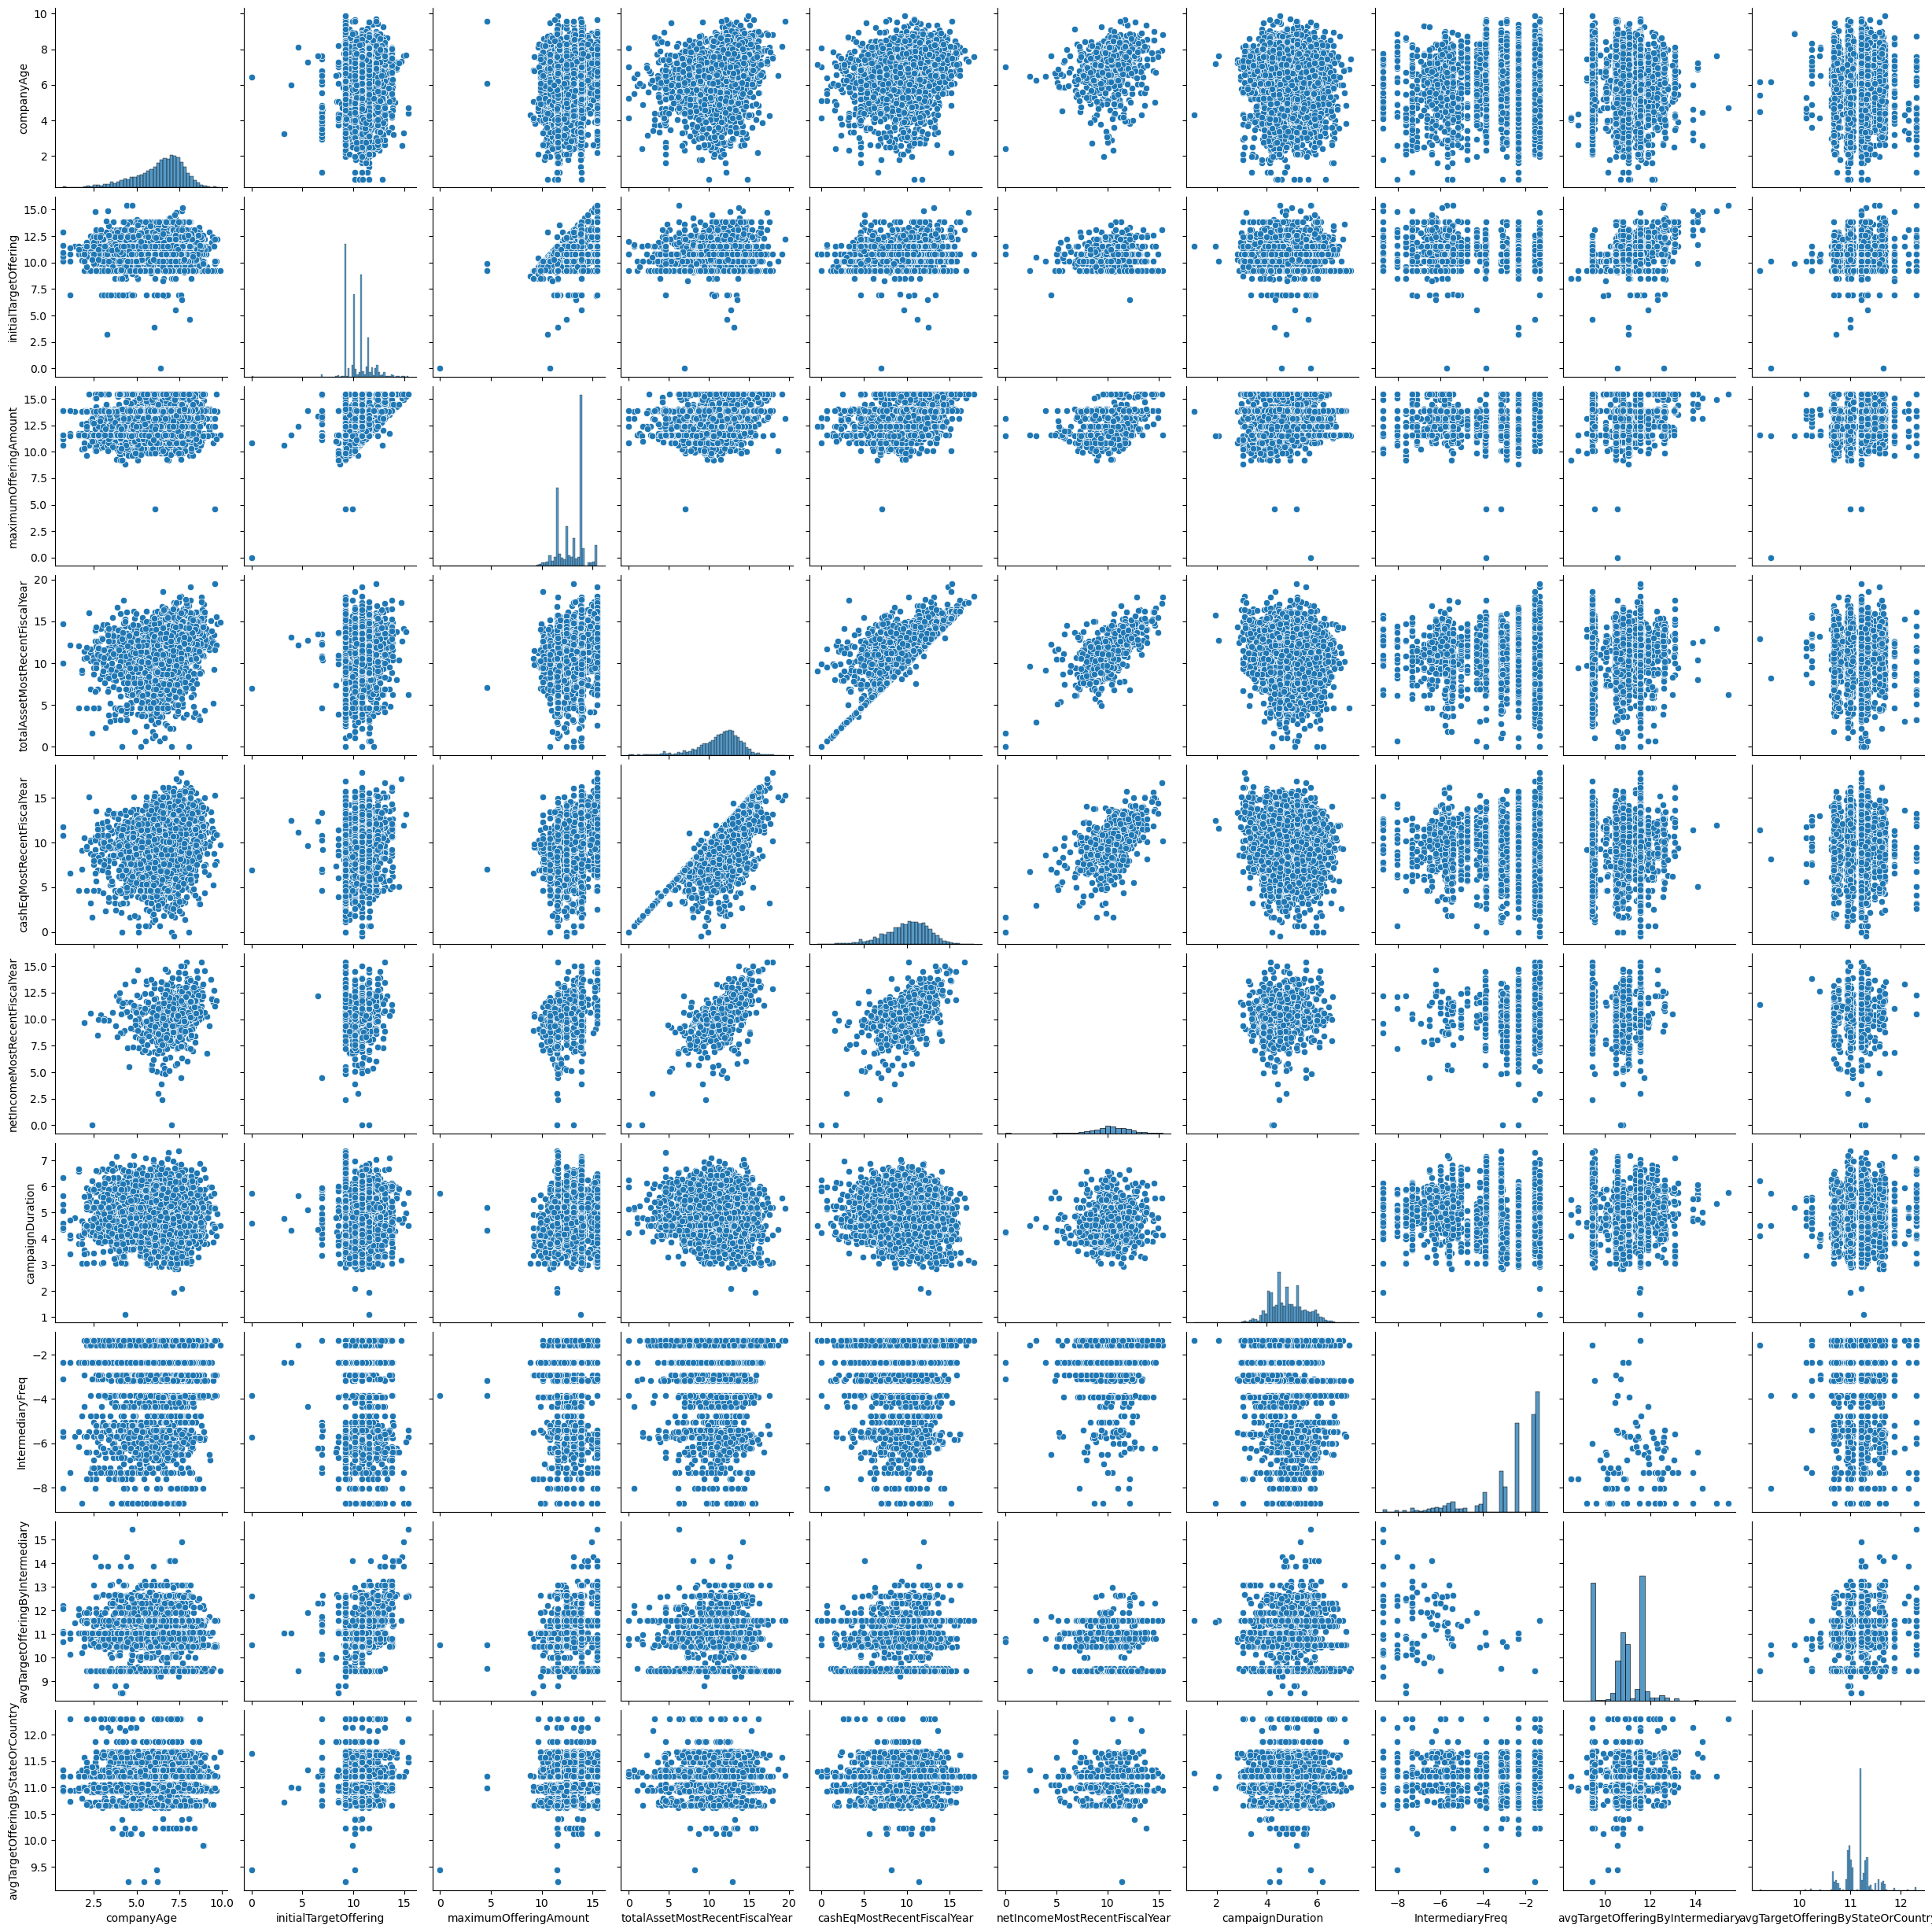

In [52]:
sns.pairplot(np.log(OH_X_train[numerical_cols_RFE]))

Amongst companyAge, totalAssetMostRecentFiscalYear, and cashEqMostRecentFiscalYear, only *companyAge* has positive values so a **Box-Cox transformation** can be applied and plotted to look more closely into the distribution

Text(0.5, 1.0, 'Histogram of Company Age following a Box-Cox Transformation')

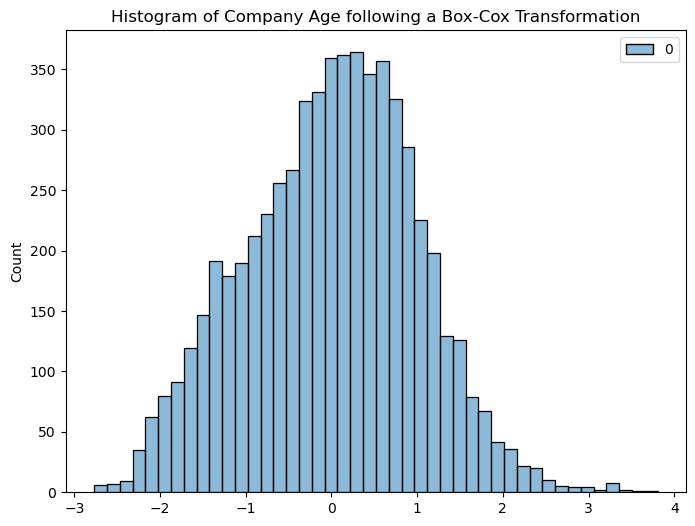

In [53]:
from sklearn.preprocessing import PowerTransformer

# Apply a Power Transformation to make the data more Gaussian-like 
pt = PowerTransformer(method='box-cox')  # You can choose 'yeo-johnson' or 'box-cox'
companyAgeBoxCox = pt.fit_transform(OH_X_train[['companyAge']]+1)

plt.figure(figsize=(8, 6))
sns.histplot(companyAgeBoxCox, kde= False)

plt.title('Histogram of Company Age following a Box-Cox Transformation')

<Axes: xlabel='campaignStatus', ylabel='companyAge_BoxCoxTransformed'>

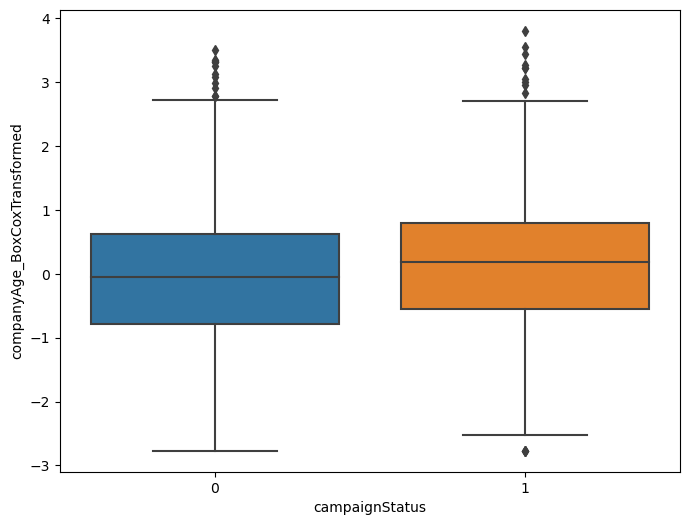

In [54]:
# Create a box plot
boxplot_df= pd.concat([ pd.DataFrame(companyAgeBoxCox), y_train], axis=1)
boxplot_df.columns = ['companyAge_BoxCoxTransformed', 'campaignStatus']

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.boxplot(x='campaignStatus', y='companyAge_BoxCoxTransformed', data= boxplot_df)

#### Anomaly Detection: Removing Outliers

In [55]:
# Define the variable name
variable_name = 'companyAge_BoxCoxTransformed'

# Calculate IQR for both 'campaignStatus' values
q25_0, q75_0 = np.percentile(boxplot_df[variable_name].loc[boxplot_df['campaignStatus'] == 0], 25), np.percentile(boxplot_df[variable_name].loc[boxplot_df['campaignStatus'] == 0], 75)
q25_1, q75_1 = np.percentile(boxplot_df[variable_name].loc[boxplot_df['campaignStatus'] == 1], 25), np.percentile(boxplot_df[variable_name].loc[boxplot_df['campaignStatus'] == 1], 75)

# Calculate IQR for both 'campaignStatus' values
iqr_0 = q75_0 - q25_0
iqr_1 = q75_1 - q25_1

# Calculate lower and upper bounds for both 'campaignStatus' values
cut_off_0 = iqr_0 * 1.8
cut_off_1 = iqr_1 * 1.8

lower_0, upper_0 = q25_0 - cut_off_0, q75_0 + cut_off_0
lower_1, upper_1 = q25_1 - cut_off_1, q75_1 + cut_off_1

# Filter outliers for 'campaignStatus' 0
outliers_0 = boxplot_df.loc[(boxplot_df['campaignStatus'] == 0) & ((boxplot_df[variable_name] < lower_0) | (boxplot_df[variable_name] > upper_0))]

print(f'no of outliers amongst unsuccessful campaigns: {len(outliers_0)}')

# Filter outliers for 'campaignStatus' 1
outliers_1 = boxplot_df.loc[(boxplot_df['campaignStatus'] == 1) & ((boxplot_df[variable_name] < lower_1) | (boxplot_df[variable_name] > upper_1))]
print(f'no of outliers amongst successful campaigns: {len(outliers_1)}')

no of outliers amongst unsuccessful campaigns: 6
no of outliers amongst successful campaigns: 6


In [56]:
OH_X_train_OutlierRemoved= OH_X_train[~(OH_X_train.index.isin(outliers_1.index) | OH_X_train.index.isin(outliers_1.index))]
y_train_OutlierRemoved= y_train[~(y_train.index.isin(outliers_1.index) | y_train.index.isin(outliers_1.index))]
OH_X_train_OutlierRemoved.reset_index(drop=True, inplace=True)
y_train_OutlierRemoved.reset_index(drop=True, inplace=True)

In [57]:
rf.fit(OH_X_train_OutlierRemoved, y_train_OutlierRemoved)
y_pred = rf.predict(OH_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       391
           1       0.73      0.74      0.73       289

    accuracy                           0.77       680
   macro avg       0.77      0.77      0.77       680
weighted avg       0.77      0.77      0.77       680



In [58]:
cv_accuracy = cross_val_score(rf, OH_X_train_OutlierRemoved,  y_train_OutlierRemoved, cv=5, scoring='accuracy') #using cross validated sample

print(f"Cross-validation accuracies:{cv_accuracy}" )
print(f"Mean accuracy:{cv_accuracy.mean()*100: .2f}")

Cross-validation accuracies:[0.76268412 0.79459902 0.79705401 0.7512275  0.76841244]
Mean accuracy: 77.48


Outlier removal resulted in a change in accuracy by 1%-point on the test data, and it also increased the recall and f1-score for unsucessful campaigns by 3-% point and 1%-point respectively. Precision, increases for successful campaigns by 2-% point while losing 2-% points on recall. Cross-validation accuracies didn't increase significantly

### Combining MLA to Make a Voting Ensemble


In [59]:
from sklearn import ensemble
from sklearn import gaussian_process
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import svm
from sklearn import tree
from sklearn import discriminant_analysis
from xgboost import XGBClassifier


ListOfMLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(max_iter=400), #max_ter changed to 200, to avoid convergence issues resulting from default 100 iterations
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
        
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
        
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]


#### Standardization Of Features For Non-Tree Based Models

In [60]:
from sklearn.preprocessing import RobustScaler

# Initialize the RobustScaler
rscaler = RobustScaler() 

OH_X_train_Standardized= OH_X_train_OutlierRemoved.copy()
OH_X_test_Standardized= OH_X_test.copy()

# Fit and transform the RobustScaler on the training data
OH_X_train_Standardized[numerical_cols_RFE] = rscaler.fit_transform(OH_X_train_OutlierRemoved[numerical_cols_RFE])
OH_X_test_Standardized[numerical_cols_RFE] = rscaler.transform(OH_X_test[numerical_cols_RFE])

In [61]:
from sklearn import model_selection

# Creating a cross validation split of 80% training data with 20% data for valdiation from
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 0 )

In [63]:
def compareMLA(OH_X_train_Standardized, y_train, OH_X_test_Standardized, y_test, ListOfMLA):
    
    #create table to compare MLA metrics
    MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    #create table to compare MLA predictions
    MLA_predict_test= pd.DataFrame()
    
    MLA_predict_test['Target'] = y_test

    #index through MLA and save performance to table
    row_index = 0

    for alg in ListOfMLA:

        #set name and parameters
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
                       
        cv_results = model_selection.cross_validate(alg, OH_X_train_Standardized, y_train, cv  = cv_split, return_train_score= True)

        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()

        #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
        MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
        

        #save MLA predictions - see section 6 for usage
        #alg.fit(X_TrainTest_Combined, y_TrainTest_Combined)
        alg.fit(OH_X_train_Standardized, y_train)
        #MLA_predict[MLA_name] = alg.predict(X_TrainTest_Combined)
        MLA_predict_test[MLA_name] = alg.predict(OH_X_test_Standardized)   

        row_index+=1
    return MLA_compare, MLA_predict_test    


In [72]:
#print and sort table
MLA_compare, MLA_predict_test = compareMLA(OH_X_train_Standardized, y_train_OutlierRemoved, OH_X_test_Standardized, y_test, ListOfMLA)
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

c:\Users\apsin\anaconda3\envs\Aadi\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\apsin\anaconda3\envs\Aadi\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\apsin\anaconda3\envs\Aadi\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\apsin\anaconda3\envs\Aadi\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warn

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.805176,0.773077,0.026533,2.214589
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.999468,0.769231,0.020065,1.863661
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.770172,0.762357,0.034056,0.482095
19,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.972197,0.754419,0.03267,0.455142
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.999509,0.749836,0.030387,1.077898
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.982979,0.743453,0.033684,0.744907
14,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.764403,0.713502,0.037223,13.069953
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.884206,0.701064,0.040919,21.930712
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.69507,0.693372,0.024005,0.00376
15,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.999509,0.690098,0.03184,0.096861


With large differences in training and test accuracies, it can be seen that RandomForestClassfier, XGBClassifier, BaggingClassifier, ExtraTreesClassifer, BaggingClassifier, GaussianProcessClassifier, DecisionTreeClassifier, ExtraTreeClassifier	are **clearly overfitting**.

The bottom 7 classifiers provide accuracies which are close to the benchmark accuracy (majority class accuracy) and therefore don't provide any value to modeling this study.


Text(0, 0.5, 'Algorithm')

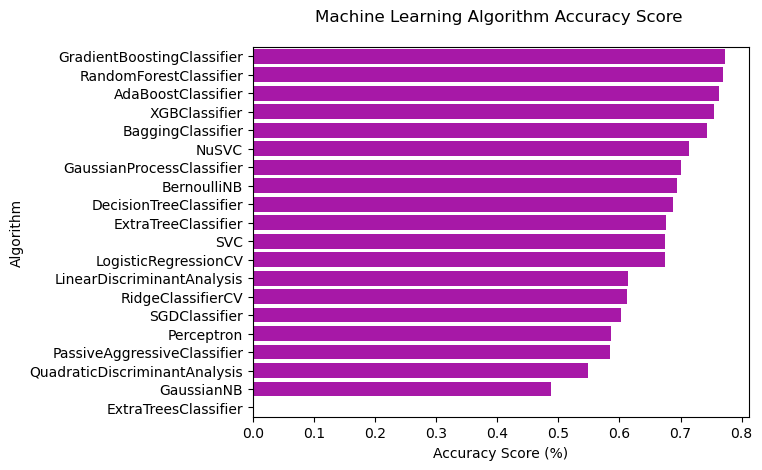

In [66]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

#### Selecting ML Algorithms for Hyper Parameter Tuning:
- Only MLA with test accuracies above 70% were considered

In [67]:
selected_MLA = [
        #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
        ('ada', ensemble.AdaBoostClassifier()),
        ('bc', ensemble.BaggingClassifier()),
        ('etsc',ensemble.ExtraTreesClassifier()),
        ('gbc', ensemble.GradientBoostingClassifier()),
        ('rfc', ensemble.RandomForestClassifier()),

        #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
        ('xgb', XGBClassifier()),

        #SVM: http://scikit-learn.org/stable/modules/svm.html
        ('nsvc', svm.NuSVC(probability=True)),

        #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
        #('bnb', naive_bayes.BernoulliNB()),
               
        ('gpc', gaussian_process.GaussianProcessClassifier())
        
        ]

#### Hyper Parameter Tuning with GridSearchCV

**Warning!** This is to be run only once to obtain the tuned parameters since it is very computationally intensive. 

In [87]:
#Defining the parameter grids for GridSearchCV

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

grid_n_estimator = [50, 100, 300, 500]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]
grid_gamma= ['scale','auto']
grid_nu= [0.3, 0.4, 0.5, 0.6, 0.7]
grid_binarize= [0.05, 0.075, 0.1, 0.25, 0.5]

grid_param = [
                [{
                #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
                'n_estimators': grid_n_estimator, #default=50
                'learning_rate': grid_learn, #default=1
                'random_state': grid_seed
                }],
                    
                [{
                #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
                'n_estimators': grid_n_estimator, #default=10
                'max_samples': grid_ratio, #default=1.0 => each base estimator will be trained on all of data
                'random_state': grid_seed
                }],
        
                [{
                #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
                'n_estimators': grid_n_estimator, #default=100
                'criterion': grid_criterion, #default= 'gini'
                'max_depth': grid_max_depth, #default=None
                'random_state': grid_seed
                }],

                [{
                #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
                'loss': ['exponential'], #default='log_loss
                'learning_rate': grid_learn,  #default: 0.1
                'n_estimators': grid_n_estimator, #default: 100                
                'max_depth': grid_max_depth, #default=3   
                'random_state': grid_seed
                }],
            
                [{
                #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
                'n_estimators': grid_n_estimator, #default=100
                'criterion': grid_criterion, #default='gini'
                'max_depth': grid_max_depth, #default=None
                'oob_score': [True], 
                'random_state': grid_seed
                }],

                [{
                #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
                'learning_rate': grid_learn, #default: .3
                'max_depth': grid_max_depth, #default 6
                'n_estimators': grid_n_estimator, 
                'seed': grid_seed   #default:100
                }],  

                [{
                #NuSVC https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html
            
                'nu': grid_nu, #default=0.5
                'gamma': grid_gamma, #default: auto
                'decision_function_shape': ['ovo', 'ovr'], #default:ovr
                'probability': [True],
                'random_state': grid_seed
                }],          
        

                [{
                #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
                'alpha': grid_ratio, #default: 1.0
                'binarize': grid_binarize
                }],
        

                [{    
                #GaussianProcessClassifier
                'max_iter_predict': grid_n_estimator, #default: 100
                'random_state': grid_seed
                }]
                
            
                ]

In [95]:
#WARNING: Running is very computational intensive and time expensive. To be done only once in order to figure out the parameters

import time

start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter

for clf, param in zip (selected_MLA, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(param)
        
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(OH_X_train_Standardized, y_train_OutlierRemoved) 
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 496.27 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 500, 'random_state': 0} with a runtime of 1682.72 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 300, 'random_state': 0} with a runtime of 436.01 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.03, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 300, 'random_state': 0} with a runtime of 14957.50 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500, 'oob_score': True, 'random_state': 0} with a runtime of 1186.84 seconds.
The best parameter for XGBClassifier is {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} with a runtime of 1297.34 seconds.
The best parameter for NuSVC 

In [68]:
selected_MLA_tuned = [
    #Ensemble Methods
    ('ada', ensemble.AdaBoostClassifier(learning_rate=0.25, n_estimators=300, random_state=0)),
    
    # Bagging classifier was excluded after the correlation map in section below showed 0.9 with Random Forests
    #('bc', ensemble.BaggingClassifier(max_samples=0.25, n_estimators=500, random_state=0)), 
    
    ('etsc',ensemble.ExtraTreesClassifier(n_estimators=300, criterion= 'entropy', max_depth=10, random_state=0)),
    
    # GradientBoostingClassifier was excluded after the correlation map in section below showed 0.93 with XGboost while being 8 times slower
    #('gbc', ensemble.GradientBoostingClassifier(learning_rate=0.03, max_depth=4, n_estimators=300, loss= 'exponential',  random_state=0)),  
    
    ('rfc', ensemble.RandomForestClassifier(n_estimators=500, criterion= 'entropy', max_depth=10, random_state=0)),

     
    ('xgb', XGBClassifier(n_estimators=300, learning_rate= 0.03, max_depth=4, random_state=0)),

    
    # The following algorithms as can be seen from the correlation heatmap in the section below have less correlation with the ensemble models
    # and therefore have the potential to diversify the model but were still excluded by trail and error resulted in reduced accuracies of the voting and stacking ensembles
     
    #('nsvc', svm.NuSVC(nu= 0.6, gamma= 'scale', decision_function_shape='ovo', probability= True, random_state=0)),
    
    #('bnb', naive_bayes.BernoulliNB(alpha=1.0, binarize=0.1)),
             
    #('gpc', gaussian_process.GaussianProcessClassifier(max_iter_predict= 50,  random_state=0))
        
        ]

In [69]:
# Comparison of the selected Algorithms after Hyper Parameter Tuning
ListOfSelectedTunedMLA= [alg for _, alg in selected_MLA_tuned] # only selecting the classifiers from the tuples of the list
MLA_compare_tuned, MLA_predict_test_tuned = compareMLA(OH_X_train_Standardized, y_train_OutlierRemoved, OH_X_test_Standardized, y_test, ListOfSelectedTunedMLA)

In [70]:
MLA_compare_tuned.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare_tuned

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.818146,0.77455,0.028845,0.898825
2,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.872606,0.774386,0.033483,7.589205
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.771052,0.757365,0.03055,2.927389
1,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.789055,0.742799,0.03119,1.224465


It can be seen that by tuning of hyper parameters, **overfitting has reduced** for all the algorithms as can be seen with reduced differences between testing and training accuracies. 

Text(0.5, 1.0, 'Pearson Correlation Heatmap of MLA Algorithms Predictions')

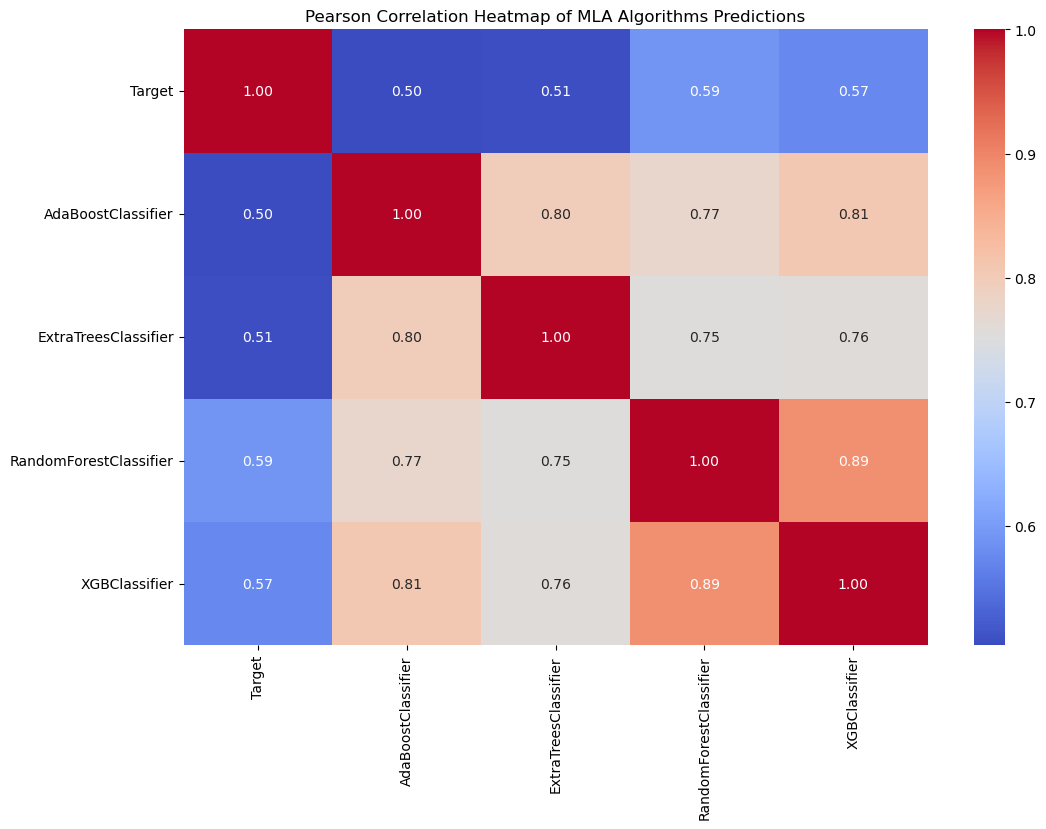

In [71]:
# Compare algorithm predictions with each other, where 1 = exactly similar and 0 = exactly opposite

plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(MLA_predict_test_tuned.corr(), annot=True, cmap='coolwarm', fmt=".2f") #Pearson correlation Heatmap
plt.title('Pearson Correlation Heatmap of MLA Algorithms Predictions')

In [159]:
#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = selected_MLA_tuned, voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, OH_X_train_Standardized, y_train_OutlierRemoved, cv  = cv_split, return_train_score= True)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 82.56
Hard Voting Test w/bin score mean: 77.02
Hard Voting Test w/bin score 3*std: +/- 3.51
----------


In [160]:
#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = selected_MLA_tuned,  voting = 'soft')
vote_soft_cv =  model_selection.cross_validate(vote_soft, OH_X_train_Standardized, y_train_OutlierRemoved, cv  = cv_split, return_train_score= True)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Soft Voting Training w/bin score mean: 83.89
Soft Voting Test w/bin score mean: 77.43
Soft Voting Test w/bin score 3*std: +/- 2.44
----------


### Stacking the Tuned Models

In [161]:
#from sklearn.ensemble import StackingClassifier

# Create a stacking classifier with a logistic regression meta-model
stacking_MLA= ensemble.StackingClassifier(estimators=selected_MLA_tuned, final_estimator= linear_model.LogisticRegressionCV(max_iter=400))
stacking_cv = model_selection.cross_validate(stacking_MLA, OH_X_train_Standardized, y_train_OutlierRemoved, cv = cv_split, return_train_score= True)

print("Stacking MLA Training w/bin score mean: {:.2f}". format(stacking_cv['train_score'].mean()*100)) 
print("Stacking MLA Test w/bin score mean: {:.2f}". format(stacking_cv['test_score'].mean()*100))
print("Stacking MLA Test w/bin score 3*std: +/- {:.2f}". format(stacking_cv['test_score'].std()*100*3))


Stacking MLA Training w/bin score mean: 83.97
Stacking MLA Test w/bin score mean: 77.55
Stacking MLA Test w/bin score 3*std: +/- 3.37


### Saving the Serialized Ensemble Models using Pickle for use in Cloud App (CrowdFundProphetApp)

Since all the three ensemble classifiers have shown good performance, these will be now fitted and subsequently saved as serialized trained models. The serialized trained model of the stackedClassifier will be used directly in my ML model cloud app for prediction, shared at my repo link: https://github.com/apsinghAnalytics/CrowdFundProphetApp

In [162]:
vote_hard.fit(OH_X_train_Standardized, y_train_OutlierRemoved) # fit the hard voting classifier
vote_soft.fit(OH_X_train_Standardized, y_train_OutlierRemoved) # fit the soft voting classifier
stacking_MLA.fit(OH_X_train_Standardized, y_train_OutlierRemoved) # fit the stacked classifier

StackingClassifier(estimators=[('ada',
                                AdaBoostClassifier(learning_rate=0.25,
                                                   n_estimators=300,
                                                   random_state=0)),
                               ('etsc',
                                ExtraTreesClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     n_estimators=300,
                                                     random_state=0)),
                               ('rfc',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=10,
                                                       n_estimators=500,
                                                       random_state=0)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=No...
                                              interaction_constraints=None,
                                              learning_rate=0.03, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=0, ...))],
                   final_estimator=LogisticRegressionCV(max_iter=400))

In [165]:
y_pred= stacking_MLA.predict(OH_X_test_Standardized)

In [166]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       391
           1       0.76      0.77      0.77       289

    accuracy                           0.80       680
   macro avg       0.80      0.80      0.80       680
weighted avg       0.80      0.80      0.80       680



The stacked classifier has resulted in an increase of 3-% point accuracy in the test data. 

### Using Pickling for Classifier and Scaler Serialization in Cloud Applications

In [163]:
import pickle #library to save ML models in serialized format

#save the trained models to be used later for the cloud app

with open('hardVotingClassifier.pkl', 'wb') as file: 
    pickle.dump(vote_hard, file)

with open('softVotingClassifier.pkl', 'wb') as file:
    pickle.dump(vote_soft, file)

with open('stackedClassifier.pkl', 'wb') as file:
    pickle.dump(stacking_MLA, file)

In [169]:
with open('rscaler.pkl', 'wb') as file:
    pickle.dump(rscaler, file) # Pickling the scaler used earlier to standardize the data

### Conclusions

A hyperparameter tuned **XGBoostClassifier** model with both training and test accuracies higher than voting classifiers is clearly **outpeforming the hardvoting ensembles**. 

The **stacked ensemble model**, which combines individual models' outputs and fine-tunes them using a basic *Logistic Regression model*, demonstrates slightly superior performance compared to the tuned individual models (including tuned XGBoostClassifier).

In this notebook, an ML model was developed to have a **cross-validated average accuracy of 77.55%, with an 80% accuracy on the validation data** against a baseline (majority class) accuracy of **57%**.    
